# Gradient Boosting Decision Trees

*NOTE: For visualizing the trees you need to install graphviz on your system: `sudo apt-get install -y graphviz`*


In [1]:
import warnings 
warnings.filterwarnings ("ignore")

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt

from utils import visualize_classifier, visualize_tree_sklearn, visualize_tree_lightgbm

plt.style.use("bmh") # Set a matplotlib style 

print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Sklearn version: {sklearn.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"Current style: {plt.rcParams['figure.facecolor']}")

Numpy version: 2.2.6
Pandas version: 2.3.2
Sklearn version: 1.7.2
LightGBM version: 4.6.0
Current style: white


## Decision Trees

A Decision Tree is a machine learning algorithm that can be used for classification or regression. The intiution behind Decision Trees is that you split the data into regions until all data points belong to each class is inside their own region.

Some details of Decision Trees:
* DT models are fairly intuitive and easy to explain to business.
* DT cut feature space in rectangles [or (hyper)cuboids].
* DT any number of categorical variables are not really an issue.
* DT overfit easily. To solve that, you can use Random Forest or Boosted Decision Trees.
* No need to normalize the features.

To train a Decision Tree we optimize a loss function that finds the optimal split. The optimal split is the one that minimizes the classification error. This is measured in terms of "purity", a pure node happens when all the elements in the node are of one unique class. There are two ways of measuring the purity of a node, using the **Gini index** or using **entropy**.

#### Gini index:

The Gini index is defined:

$$
Gini (node) = \sum_{k=1}^c p_k(1-p_k) 
$$

where $p_k$ is the probability of picking a data poing from class k.

Details:
* Gini is a measure of variance in the node.
* Gini is high if there are many data points belonging to the wrong class.
* Gini is zero if all the data points belong to the same class. 
* Gini is faster to compute than Entropy.
* Also used in economics to measure inequality.

#### Entropy

The entropy is defined as:

$$
Entropy (node) = \sum_{k=1}^c p_k log_2 (p_k)
$$

where $p_k$ is the probability of picking a data point from class k.

Details:
* Entropy is a measure of uncertainty in the node.
* Entropy is high if there are many data points belonging to the wrong class.
* Entropy is zero if all the data points belong to the same class. 
* Entropy is slower to compute than Gini.
* It is used in statistics to measure the expected amount of information that can be drawn from a distribution.


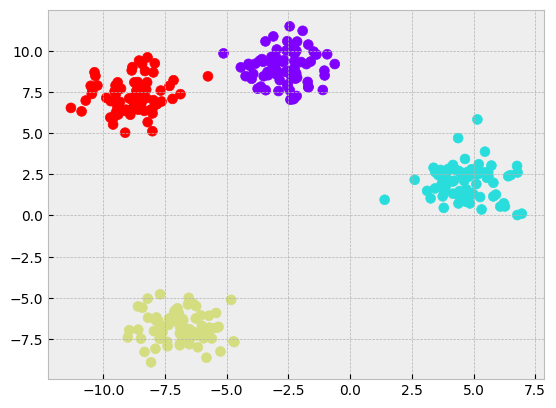

In [3]:
X, y = make_blobs(n_samples=300, centers=4, random_state=42, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

In [4]:
model = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=1)

In [5]:
model = model.fit(X, y)
print(f"Tree depth: {model.get_depth()}")
print(f"Number of leaves: {model.get_n_leaves()}")

Tree depth: 1
Number of leaves: 2


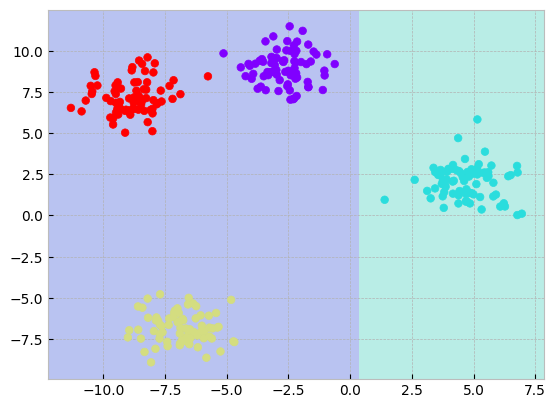

In [6]:
visualize_classifier(model, X, y)

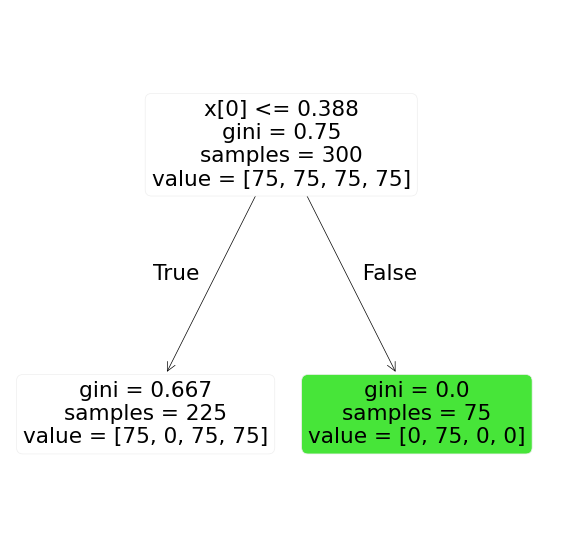

In [7]:
visualize_tree_sklearn(model)

In [8]:
model = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=2)

In [9]:
model = model.fit(X, y)
print(f"Tree depth: {model.get_depth()}")
print(f"Number of leaves: {model.get_n_leaves()}")

Tree depth: 2
Number of leaves: 3


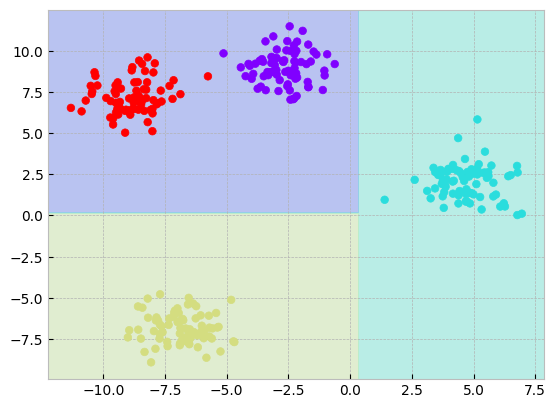

In [10]:
visualize_classifier(model, X, y)

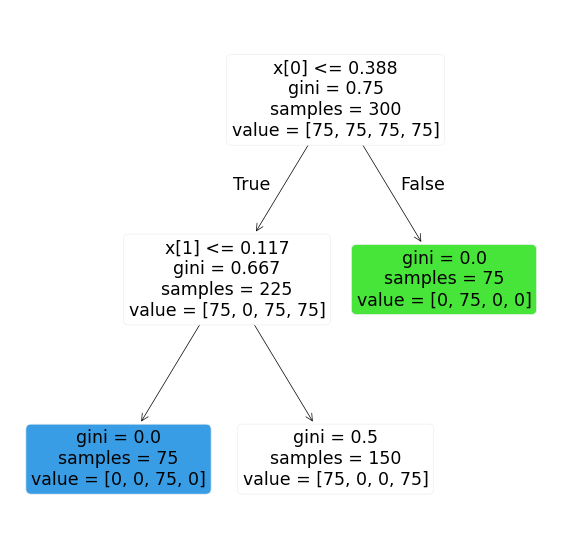

In [11]:
visualize_tree_sklearn(model)

In [12]:
model = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=None)

In [13]:
model = model.fit(X, y)
print(f"Tree depth: {model.get_depth()}")
print(f"Number of leaves: {model.get_n_leaves()}")

Tree depth: 3
Number of leaves: 4


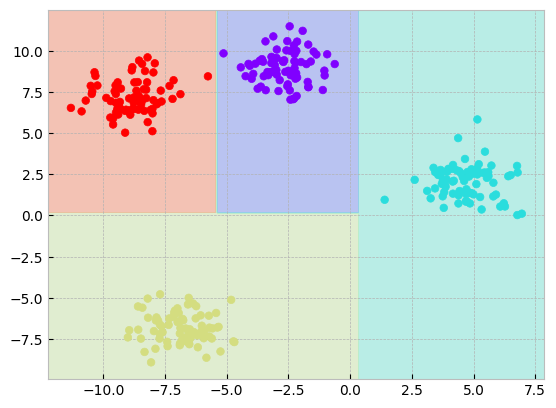

In [14]:
visualize_classifier(model, X, y)

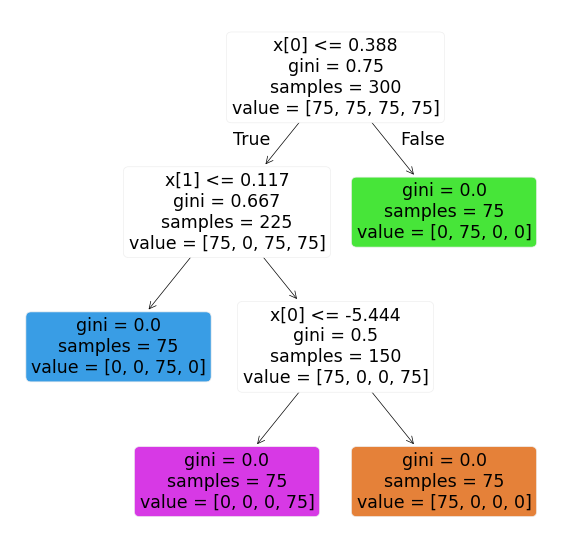

In [15]:
visualize_tree_sklearn(model)

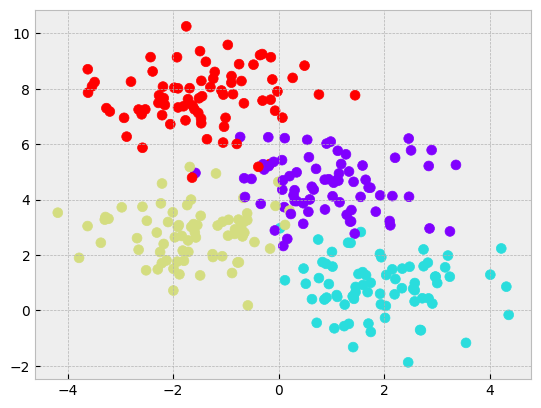

In [16]:
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

In [17]:
model = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=None)

In [18]:
model = model.fit(X, y)
print(f"Tree depth: {model.get_depth()}")
print(f"Number of leaves: {model.get_n_leaves()}")

Tree depth: 10
Number of leaves: 24


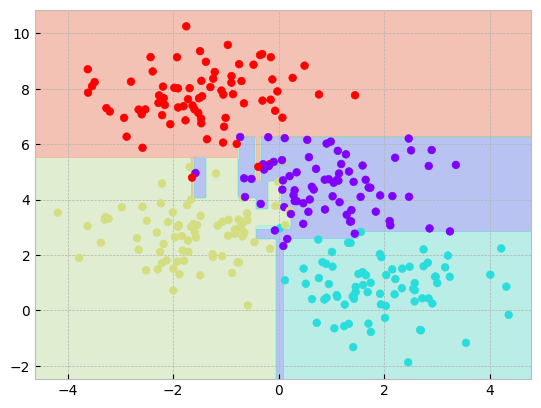

In [19]:
visualize_classifier(model, X, y)

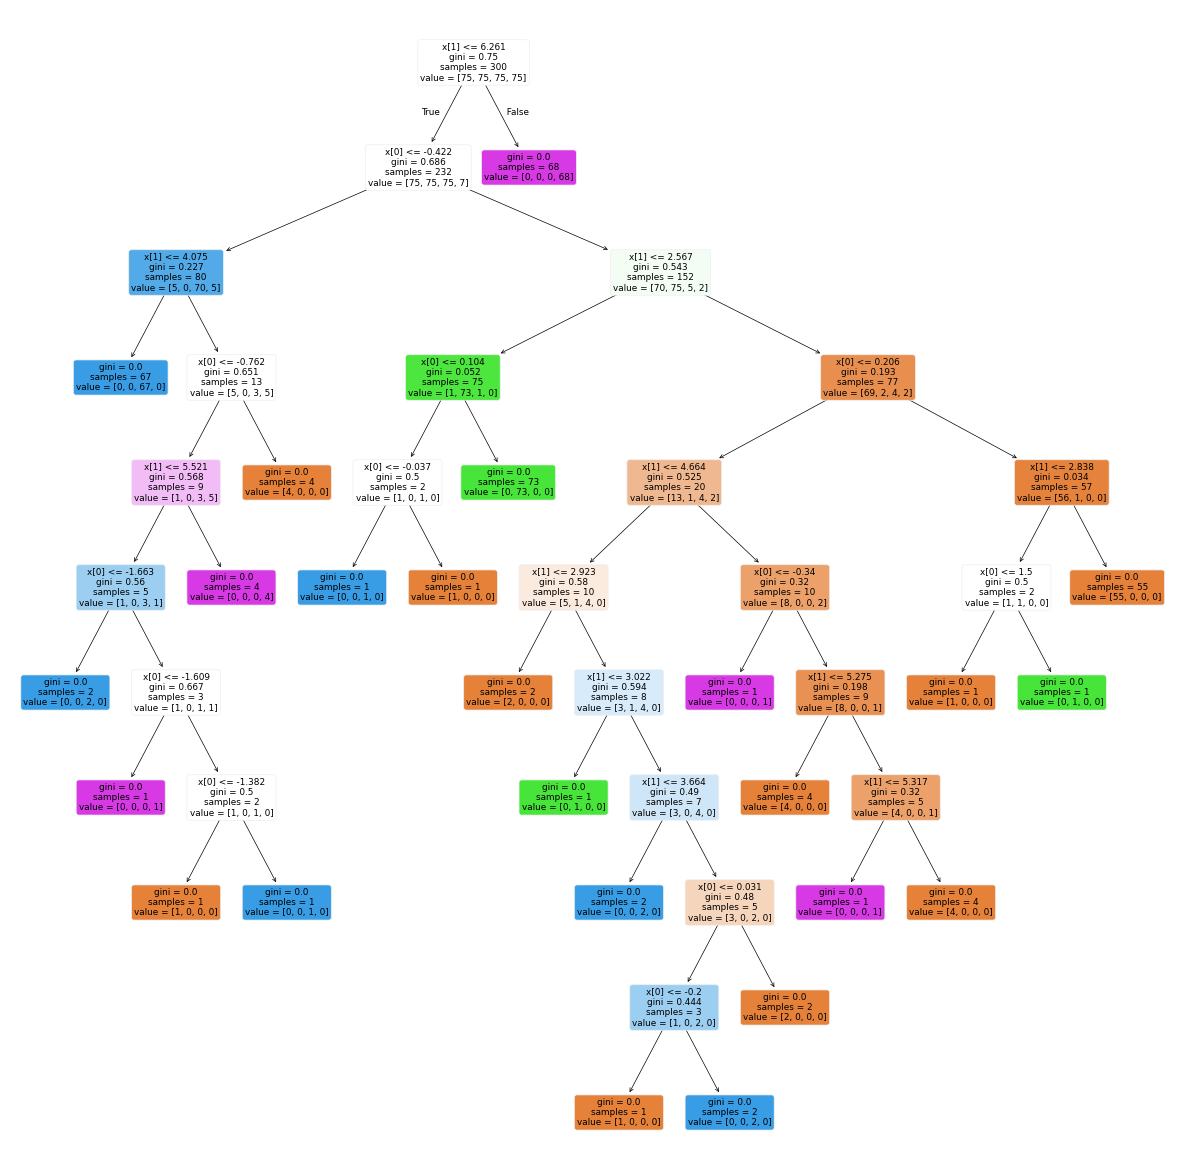

In [20]:
visualize_tree_sklearn(model, figsize=(15,15))

Tree depth: 3
Number of leaves: 5


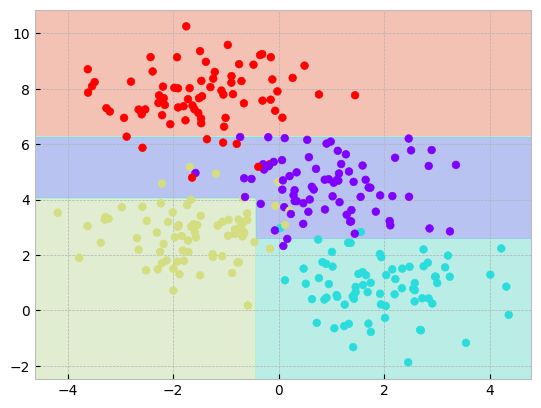

In [21]:
model = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=3)
model = model.fit(X, y)
print(f"Tree depth: {model.get_depth()}")
print(f"Number of leaves: {model.get_n_leaves()}")
visualize_classifier(model, X, y)

## Gradient Boosting Decision Trees

Gradient boosting is a machine learning technique that produces a prediction model in the form of an ensemble of weak classifiers. One of the most popular types of gradient boosting is gradient boosted decision trees (GBDT), that internally is made up of an ensemble of weak decision trees.

The two most popular GBDT frameworks are XGBoost and LightGBM. Both frameworks uses efficient and scalable implementations for gradient boosting that can be used for classification and regression.

Boosting is a technique that builds strong classifiers by sequentially emsambling weak ones. First, a model is trained on the data. Then a second model tries to correct the errors found in the first model. This process is repeated until the error is reduced to a limit or a maximum number of models is added.

In ADA boost, we take the data points that had bad performance and they are weighted more in the next model. In gradient boosting, we take the residual, which is the difference between the true labels $y$ and the labels predicted by the model $\hat y$.

* For the first estimator, the residual is $y - f_1(x)$.
* For the second estimator, the residual is $y - f_1(x) - f_2(x)$.
* For the $n^{th}$ estimator, the residual is $y - \sum_{i=1}^n f_n(x)$

To train the GBDT, we want to minimize a loss which the difference between the true and predicted labels and we add a regularization term $\Omega$ to reduce the complexity of the model.

$$ \mathcal {L} = \sum_{i=1}^n l(y_i, \hat y_i) + \sum_{i=1}^n \Omega (f_i)$$


The loss term $\sum_{i=1}^n l(y_i, \hat y_i)$ is not easy to compute, one way is via a Taylor expansion. A Taylor expansion is a way to approximate a complex function based on its derivative (gradient or Jacobian) and second derivate (Hessian). In particular, the hessian is not easy to compute, and this is one of the reasons finding the right split in gradient boosting trees can be difficult.

To find the optimal split, instead of computing the Gini or the entropy, GBDT computes a gain that has into account the gradient, the hessian and other terms.

There are two different strategies to compute the trees: level-wise and leaf-wise. 

<img src="./img/DecisionTrees_3_thumb.png" />

The level-wise strategy grows the tree level by level. In this strategy, each node splits the data prioritizing the nodes closer to the tree root. The leaf-wise strategy grows the tree by splitting the data at the nodes with the highest loss change. 

Level-wise growth is usually better for smaller datasets whereas leaf-wise tends to overfit. Leaf-wise growth tends to excel in larger datasets where it is considerably faster than level-wise growth.

A key challenge in training boosted decision trees is the computational cost of finding the best split for each leaf. Conventional techniques find the exact split for each leaf, and require scanning through all the data in each iteration. 

A different approach approximates the split by building histograms of the features. That way, the algorithm doesn't need to evaluate every single value of the features to compute the split, but only the bins of the histogram, which are bounded. This approach turns out to be much more efficient for large datasets, without adversely affecting accuracy.

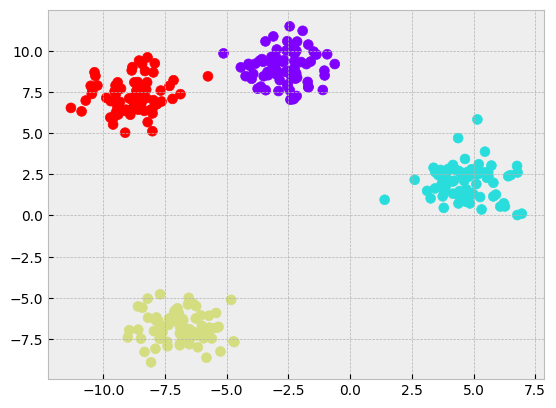

In [22]:
X, y = make_blobs(n_samples=300, centers=4, random_state=42, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

In [23]:
model = lgb.LGBMClassifier(boosting_type="gbdt", random_state=42, max_depth=None)

In [24]:
model = model.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 2
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

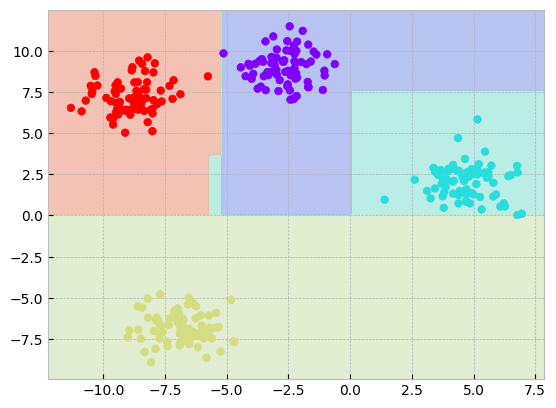

In [25]:
visualize_classifier(model, X, y)

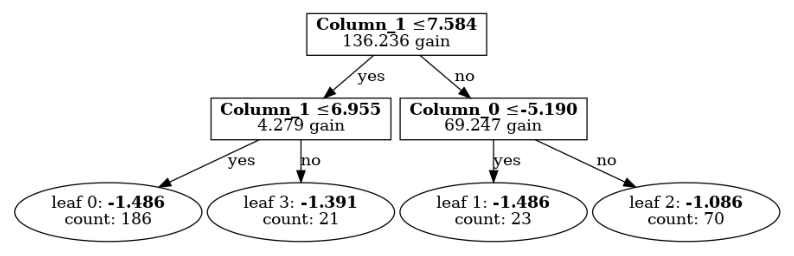

In [26]:
visualize_tree_lightgbm(model)

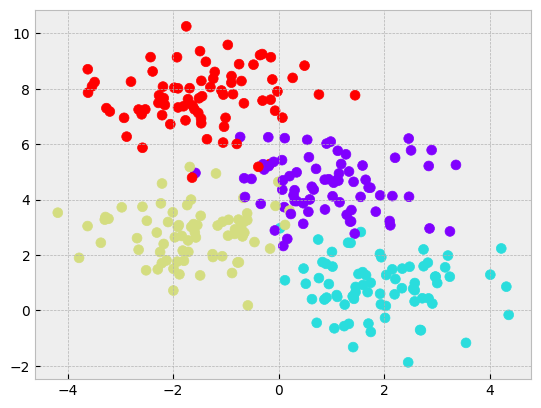

In [27]:
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

In [28]:
model = lgb.LGBMClassifier(boosting_type="gbdt", random_state=42, max_depth=None)

In [29]:
model = model.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 2
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

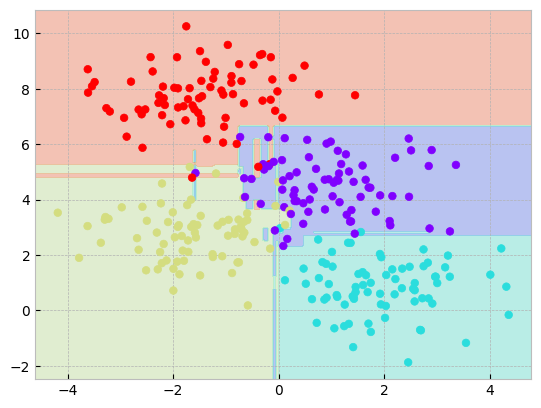

In [30]:
visualize_classifier(model, X, y)

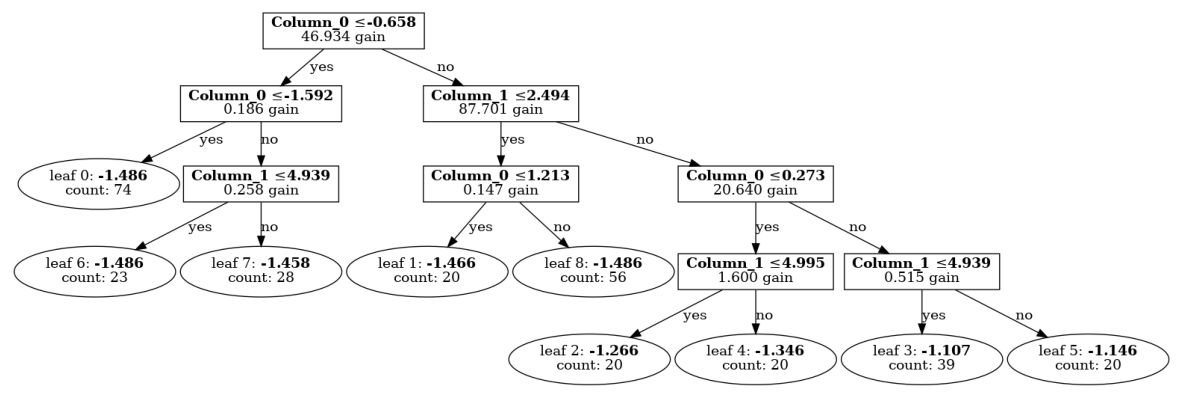

In [31]:
visualize_tree_lightgbm(model, figsize=(15,15))

## Random Forests

Random Forest is a machine learning model that can be used for general classification or regression problems. It is an improvement on top of Decision Trees and help to overcome the overfitting of these models.

In particular, Random Forest use a technique called bagging, short of boostrap aggregation. The data is randomly divided in a number of bags, and on each bag we put around 60% of the data. Then we train a decision tree on each bag and compute the ensemble of these models. The training of Random Forest is done in parallel.

An interesting detail is that when we build the subsample the data to generate the bags, we add the data with replacement (this means that the same data can go to the same bag). Adding data with replacement ensures that we don't run out of datapoints, and that each bag is large enough to be a good representation of the full dataset.

Bagging is actually independent of the algorithm, even though it is used in Random Forest, it can also be used in Gradient Boosting Decision Trees or other machine learning algorithms.

In terms of training, a Decision Tree is trained on each of the bags. For finding the optimal split, we use the same measures of purity that are used in individual Decision Trees, the Gini index or the entropy. 

Gini index is a meassure of the variance of datapoints on each node. If we have a lot of data point belonging to the wrong class, the Gini index is high, if all the data points belong to the same class, Gini is zero. 

The other way of computing the optimal split is using entropy. Entropy takes a probabilistic approach and treat each node as a probability distribution of the data. It measures the uncertainty of the node, if there are a lot of data points of the wrong class, the node doesn't have a lot of certainty and the entropy is high. However, if all the datapoints belong to the same class, the node has complete certainty about the class of the data, and the entropy is zero. 

After all the trees have been trained on each bag, we create an ensamble of all trees. This is a mayority vote, we ask a prediction for each tree and get the most voted class. Using ensambles is a very good way of improving generalization and reducing overfitting.


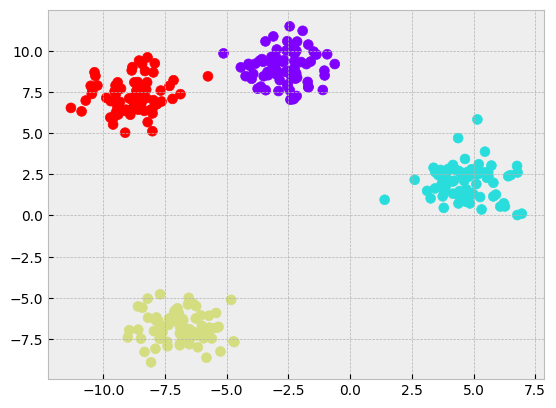

In [32]:
X, y = make_blobs(n_samples=300, centers=4, random_state=42, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

In [33]:
model = lgb.LGBMClassifier(boosting_type="random_forest", random_state=42, max_depth=None, bagging_fraction=0.6, bagging_freq=1)

In [34]:
model = model.fit(X, y)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 2
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


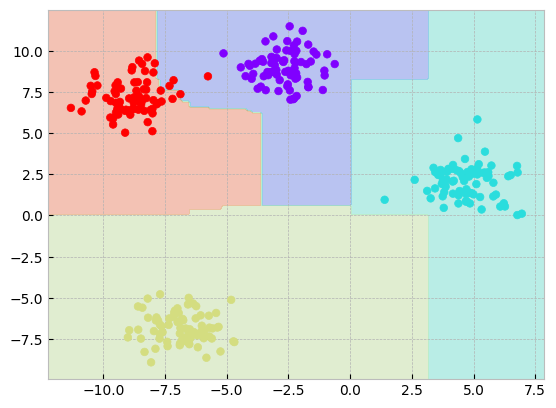

In [35]:
visualize_classifier(model, X, y)

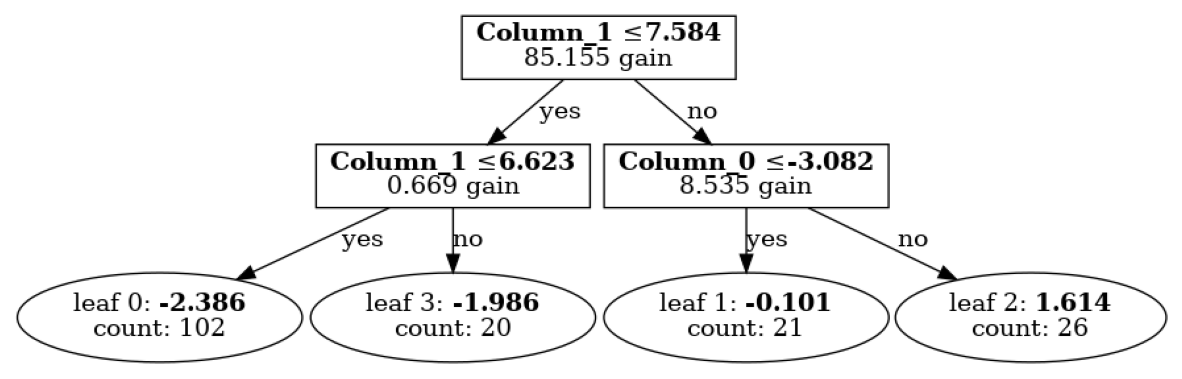

In [36]:
visualize_tree_lightgbm(model, figsize=(15,15))

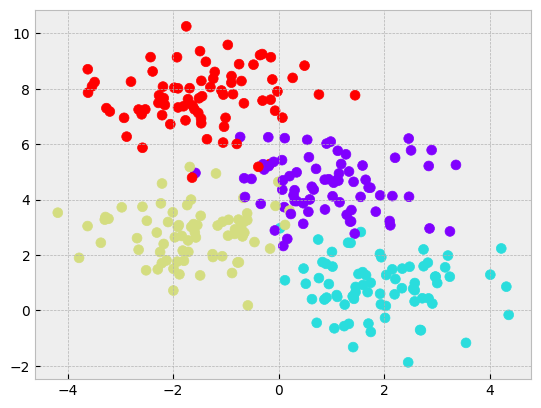

In [37]:
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

In [38]:
model = lgb.LGBMClassifier(boosting_type="random_forest", random_state=42, max_depth=None, bagging_fraction=0.6, bagging_freq=1)

In [39]:
model = model.fit(X, y)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 2
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


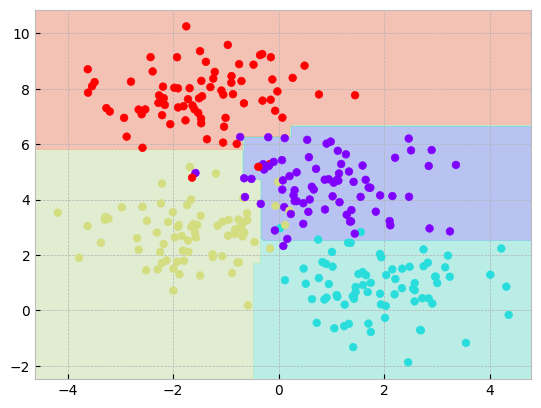

In [40]:
visualize_classifier(model, X, y)

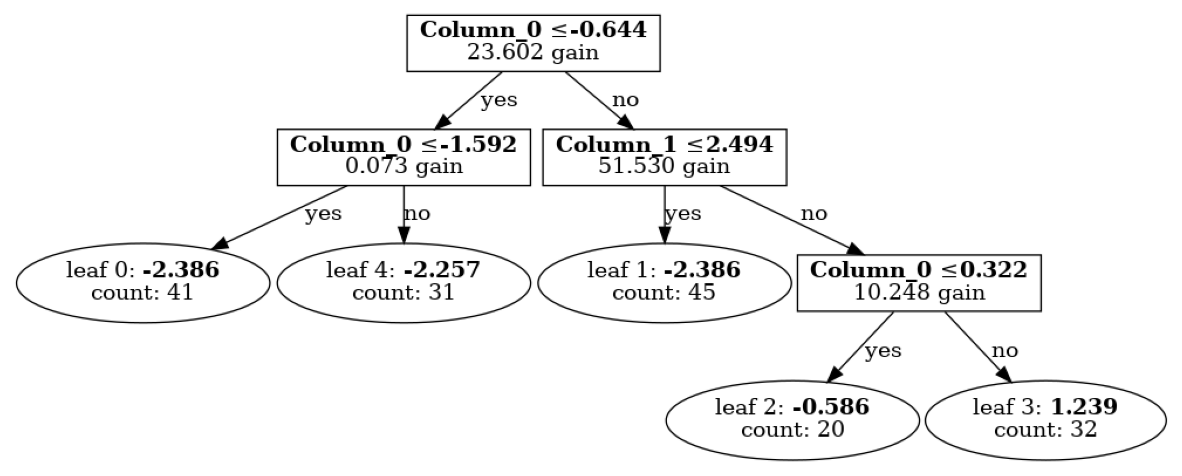

In [41]:
visualize_tree_lightgbm(model, figsize=(15,15))

## Practical tricks to excel with LightGBM

One of the biggest problems of LightGBM is that it has a large number of parameters that can be tuned. More than 130 according to their [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html).

Some advice can be found in their [parameter tuning site](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#deal-with-over-fitting).

**For better accuracy**
* Use large `max_bin`. LightGBM use histograms to approximate speed up the data split operation, the higher the number of bins, the more the histogram is similar to the real data, but the slower the computation.
* Use small `learning_rate` with `large num_iterations`. This slows down the training but it make the model to learn better.
* Use large `num_leaves`. May cause overfitting, the model is more complex, but the accuracy will be better.
* Use a bigger training dataset
* Try `dart` algorithm. [DART](https://arxiv.org/abs/1505.01866) is a method that uses dropout, very common in Neural Networks, to improve the model generalization.

**For dealing with overfitting**
* Use small `max_bin`. Less histogram bins makes the split process faster.
* Use small `num_leaves`. Less leaves enforces the model to reduce its complexity and generalize better.
* Use `min_data_in_leaf` and `min_sum_hessian_in_leaf`. Can help with generalization by making sure that each leaf has a minimum number of datapoints to avoid outliers.
* Use bagging by setting `bagging_fraction` and `bagging_freq`. We subsample the dataset and train each tree with a fraction of the data, this protects against overfitting and increases the training speed.
* Use feature sub-sampling by set `feature_fraction`. Instead of sub-sampling the data, we select a fraction of the features in each iteration. This can also improve generalization, but if the features are very different quantitatively between each other, this method can cause problems. 
* Use a bigger training dataset.
* Try `lambda_l1`, `lambda_l2` and `min_gain_to_split` for regularization. Finding a good regularization value improve generalization.
* Try `max_depth` to avoid growing deep tree. Complex trees tend to overfit. 
* Try `extra_trees`. Extremely randomize tree method select the split by randomly choosing only one threshold for each feature. This increases the training speed and reduces overfitting.
* Try increasing `path_smooth`. This prevents the model to create leaves with few samples. 



## References
* Decision Trees vs LightGBM experiments: https://mljar.com/machine-learning/decision-tree-vs-lightgbm/
* Lessons Learned From Benchmarking Fast Machine Learning Algorithms: https://docs.microsoft.com/en-us/archive/blogs/machinelearning/lessons-learned-benchmarking-fast-machine-learning-algorithms
* Decision Tree Learning https://en.wikipedia.org/wiki/Decision_tree_learning
* Gradient Boosting https://en.wikipedia.org/wiki/Gradient_boosting
* LightGBM parameter documentation: https://lightgbm.readthedocs.io/en/latest/Parameters.html
* LightGBM parameter tuning documentation: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#deal-with-over-fitting
